In [1]:
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup
from random import randint
from time import sleep
from joblib import dump, load
import joblib
import os
import glob
# Custom Functions
from Weight_Map import map_categories
from EP_funs import time_to_minutes, compare_columns, Raw_Data_Filter, data_collector, convert_to_float
# Adjust below to fit the date of the run
rd = '052625' 
patha = r'/home/robs/Downloads/Upcoming_Events' # Projection Saved Places
pathb = r'MBIDK_MMA' # Models

In [2]:
# Upcoming event info scraped
###########
# This script will return the following items for the upcoming event on the the fightmetric website:
#    - Event Title  (String)
#    - Event Date   (String)
#    - Event Location   (String)
#    - Fighter list A   (List of strings)
#    - Fighter list B   (List of strings)
# 44 mins to write this with old code and internet help
# > than a min runtime
#######
# Fetch initial event page
url = 'http://www.ufcstats.com/statistics/events/completed?page=1'
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
Event_urls = []
# Collect event URLs
for a in soup.find_all('a', href=True):
    Event_urls.append(a['href'])
# Filter event URLs of interest This Grabs the first event on the webpage aka the upcoming event; whereas 6:7 will grab the last 
# event that occured.
Upcoming_Event = Event_urls[5:6] 
Upcoming_Event
for UE in Upcoming_Event:
    response = requests.get(UE)
    soup_event = BeautifulSoup(response.content ,"html.parser")
Event_Title=soup_event.find('span', attrs={"b-content__title-highlight"}).text.strip()
Event_Date=soup_event.find('i', attrs={"b-list__box-item-title"}).next.next.strip()
Event_Location=soup_event.find('i', attrs={"b-list__box-item-title"}).next.next.next.next.next.next.next.next.strip()
print(Event_Title, Event_Date, Event_Location)
#
UE_FighterNames = soup_event.find_all("a", attrs={"b-link b-link_style_black"})
Fighter_Names = []
for name in UE_FighterNames:
    test = name.text.strip()
    if test == 'View':
        pass
    elif test == "View Matchup":
        pass
    else:
        Fighter_Names.append(test)
Fighter_A=Fighter_Names[::2]
Fighter_B=Fighter_Names[1::2]
print(Fighter_A, Fighter_B)
data = {
    "Name_A": Fighter_A,
    "Name_B": Fighter_B,
    "Date": Event_Date,
    "Location": Event_Location,
    "Title": Event_Title
}
# Convert the dictionary into a pandas DataFrame
UCI = pd.DataFrame(data)
UCI['Date'] = pd.to_datetime(UCI['Date']) 
UCI['Name_A'] = UCI['Name_A'].str.strip()
UCI['Name_B'] = UCI['Name_B'].str.strip()

UFC 315: Muhammad vs. Della Maddalena May 10, 2025 Montreal, Quebec, Canada
['Belal Muhammad', 'Valentina Shevchenko', 'Jose Aldo', 'Alexa Grasso', 'Benoit Saint Denis', 'Mike Malott', 'Jessica Andrade', 'Modestas Bukauskas', 'Navajo Stirling', 'Marc-Andre Barriault', 'Daniel Santos', 'Brad Katona'] ['Jack Della Maddalena', 'Manon Fiorot', 'Aiemann Zahabi', 'Natalia Silva', 'Kyle Prepolec', 'Charles Radtke', 'Jasmine Jasudavicius', 'Ion Cutelaba', 'Ivan Erslan', 'Bruno Silva', 'JeongYeong Lee', 'Bekzat Almakhan']


In [3]:
# Load and transform data
Full_df = pd.read_excel("/home/robs/Full_Raw_Data.xlsx")
Full_df['Date'] = pd.to_datetime(Full_df['Date']) 
Full_df['Outcome_A'] = Full_df['Outcome_A'].str.strip()
Full_df['Name_A'] = Full_df['Name_A'].str.strip()
Full_df['Name_B'] = Full_df['Name_B'].str.strip()
# Extract takedown data
Full_df['Takedowns_Fighter_A'] = pd.to_numeric(
    Full_df['Takedowns_A'].str.strip("[]").str.split(",").str[0].str.strip(" '"))
Full_df['Takedowns_Attempts_A'] = pd.to_numeric(
    Full_df['Takedowns_A'].str.strip("[]").str.split(",").str[2].str.strip(" '"))
Full_df['Takedowns_Fighter_B'] = pd.to_numeric(
    Full_df['Takedowns_B'].str.strip("[]").str.split(",").str[0].str.strip(" '"))
Full_df['Takedowns_Attempts_B'] = pd.to_numeric(
    Full_df['Takedowns_B'].str.strip("[]").str.split(",").str[2].str.strip(" '"))
# Convert percentages to floats
def percent_to_float(x, default_val):
    if isinstance(x, str) and '%' in x:
        return float(x.strip('%')) / 100
    elif x == '---':
        return default_val
    return x
Full_df['Sig_Strike_Percentage_A'] = Full_df['Sig_Strike_Percentage_A'].apply(lambda x: percent_to_float(x, -1)).astype(float)
Full_df['Sig_Strike_Percentage_B'] = Full_df['Sig_Strike_Percentage_B'].apply(lambda x: percent_to_float(x, -1)).astype(float)
Full_df['Takedown_Acc_A'] = Full_df['Takedown_Acc_A'].apply(lambda x: percent_to_float(x, -1)).astype(float)
Full_df['Takedown_Acc_B'] = Full_df['Takedown_Acc_B'].apply(lambda x: percent_to_float(x, -1)).astype(float)
# Loop through different sample sizes, these values are determined by comparing these Projections against actual performance, this is 
# is one of the areas that can be improved
samplesize_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for dis_n in samplesize_list:
    good = 0
    bad = 0
    # Data containers
    Name_A = []
    Name_B = []
    Date_of_Event = []
    Sig_Strikes_A = []
    Sig_Strikes_B = []
    Sig_Strikes_Acc_A = []
    Sig_Strikes_Acc_B = []
    Tot_Strikes_A = []
    Tot_Strikes_B = []
    Takedown_Acc_A = []
    Takedown_Acc_B = []
    Subs_A = []
    Subs_B = []
    Reversal_A = []
    Reversal_B = []
    Takedowns_Attempt_A = []
    Takedowns_Attempt_B = []
    # Iterate over fighter pairs
    for Name_A_zip, Name_B_zip, Date_zip in zip(UCI['Name_A'], UCI['Name_B'], UCI['Date']):
        try:
            X_A = Raw_Data_Filter(Name_A_zip, dis_n, Date_zip, Full_df)
            X_B = Raw_Data_Filter(Name_B_zip, dis_n, Date_zip, Full_df)
            if len(X_A) >= dis_n and len(X_B) >= dis_n:
                Fighter_A_Averages = data_collector(Name_A_zip, X_A)
                Fighter_B_Averages = data_collector(Name_B_zip, X_B)
                Name_A.append(Name_A_zip)
                Name_B.append(Name_B_zip)
                Date_of_Event.append(Date_zip)
                Sig_Strikes_A.append(Fighter_A_Averages.iloc[0])
                Sig_Strikes_B.append(Fighter_B_Averages.iloc[0])
                Sig_Strikes_Acc_A.append(Fighter_A_Averages.iloc[1])
                Sig_Strikes_Acc_B.append(Fighter_B_Averages.iloc[1])
                Tot_Strikes_A.append(Fighter_A_Averages.iloc[2])
                Tot_Strikes_B.append(Fighter_B_Averages.iloc[2])
                Takedown_Acc_A.append(Fighter_A_Averages.iloc[3])
                Takedown_Acc_B.append(Fighter_B_Averages.iloc[3])
                Subs_A.append(Fighter_A_Averages.iloc[4])
                Subs_B.append(Fighter_B_Averages.iloc[4])
                Reversal_A.append(Fighter_A_Averages.iloc[5])
                Reversal_B.append(Fighter_B_Averages.iloc[5])
                Takedowns_Attempt_A.append(Fighter_A_Averages.iloc[6])
                Takedowns_Attempt_B.append(Fighter_B_Averages.iloc[6])
                good += 1
        except Exception as e:
            print(f"Error processing {Name_A_zip} vs {Name_B_zip} on {Date_zip}: {e}")
            bad += 1
    # Compile results into DataFrame
    data = {
        "Name_A": Name_A,
        "Name_B": Name_B,
        "Event_Date": Date_of_Event,
        "Sig_Strikes_A": Sig_Strikes_A,
        "Sig_Strikes_B": Sig_Strikes_B,
        "Sig_Strikes_Acc_A": Sig_Strikes_Acc_A,
        "Sig_Strikes_Acc_B": Sig_Strikes_Acc_B,
        "Tot_Strikes_A": Tot_Strikes_A,
        "Tot_Strikes_B": Tot_Strikes_B,
        "Takedown_Acc_A": Takedown_Acc_A,
        "Takedown_Acc_B": Takedown_Acc_B,
        "Subs_A": Subs_A,
        "Subs_B": Subs_B,
        "Reversal_A": Reversal_A,
        "Reversal_B": Reversal_B,
        "Takedown_Attempts_A": Takedowns_Attempt_A,
        "Takedowns_Attempts_B": Takedowns_Attempt_B
    }
    df_test = pd.DataFrame(data)
    # Optional: Export to Excel
    output_path = f"/home/robs/Downloads/Upcoming_Events/{rd}_{dis_n}_SampleSize_Upcoming_Event.xlsx"
    df_test.to_excel(output_path, index=False)
    print(f"Saved: {output_path} | Good: {good}, Bad: {bad}")


Error processing Navajo Stirling vs Ivan Erslan on 2025-05-10 00:00:00: object of type 'NoneType' has no len()
Error processing Brad Katona vs Bekzat Almakhan on 2025-05-10 00:00:00: object of type 'NoneType' has no len()
Saved: /home/robs/Downloads/Upcoming_Events/052625_2_SampleSize_Upcoming_Event.xlsx | Good: 10, Bad: 2
Error processing Benoit Saint Denis vs Kyle Prepolec on 2025-05-10 00:00:00: object of type 'NoneType' has no len()
Error processing Navajo Stirling vs Ivan Erslan on 2025-05-10 00:00:00: object of type 'NoneType' has no len()
Error processing Brad Katona vs Bekzat Almakhan on 2025-05-10 00:00:00: object of type 'NoneType' has no len()
Saved: /home/robs/Downloads/Upcoming_Events/052625_3_SampleSize_Upcoming_Event.xlsx | Good: 9, Bad: 3
Error processing Benoit Saint Denis vs Kyle Prepolec on 2025-05-10 00:00:00: object of type 'NoneType' has no len()
Error processing Navajo Stirling vs Ivan Erslan on 2025-05-10 00:00:00: object of type 'NoneType' has no len()
Error pr

In [4]:
import pandas as pd
import os
import glob
import joblib
from collections import Counter
# Convert the Projection Columns into the same format that the models were trained with, this should be done eariler in the process
# or even just keeping the naming consistent throughout, improvment area.
column_mapping = {
    'Sig_Strikes_A': 'Sig_Strike_A',
    'Sig_Strikes_Acc_A': 'Sig_Strike_Percentage_A',
    'Tot_Strikes_A': 'Total_Strikes_Landed_A',
    'Sig_Strikes_B': 'Sig_Strike_B',
    'Sig_Strikes_Acc_B': 'Sig_Strike_Percentage_B',
    'Tot_Strikes_B': 'Total_Strikes_Landed_B'
}
# Load files and models
all_files = glob.glob(os.path.join(patha, "*.xlsx"))
models_list = {
    filename: joblib.load(os.path.join(pathb, filename))
    for filename in os.listdir(pathb) if filename.endswith('.sav')
}
# Result Storage
all_predictions = []
# Gather Projections from each file
for file in all_files:
    df = pd.read_excel(file)
    df = df.rename(columns=column_mapping)
    # Get names for applying the results easier, whats the point in predicting who wins what when you don't have the names lmao.
    names = df[['Name_A', 'Name_B']].copy()
    # Features to predict
    X = df[[
        'Sig_Strike_A',
        'Sig_Strike_Percentage_A',
        'Total_Strikes_Landed_A',
        'Sig_Strike_B',
        'Sig_Strike_Percentage_B',
        'Total_Strikes_Landed_B'
    ]]
    # Predict using all the models in the prod envi
    for model_name, model in models_list.items():
        preds = model.predict(X)
        pred_df = names.copy()
        pred_df['prediction'] = preds
        pred_df['model'] = model_name
        all_predictions.append(pred_df)
combined_df = pd.concat(all_predictions, ignore_index=True)
summary_df = combined_df.groupby(['Name_A', 'Name_B', 'prediction']).size().unstack(fill_value=0).reset_index()
summary_df = summary_df.rename(columns={0: 'A_Pred_Loses', 1: 'A_Pred_Win'})

In [5]:
def determine_predicted_winner_with_confidence(df):
    # Total predictions per row
    df['Total_Runs'] = df['A_Pred_Win'] + df['A_Pred_Loses']
    
    # Determine winner and confidence (lmao, not the correct term but it works)
    def get_winner_and_confidence(row):
        if row['A_Pred_Win'] > row['A_Pred_Loses']:
            return row['Name_A'], row['A_Pred_Win'] / row['Total_Runs']
        elif row['A_Pred_Loses'] > row['A_Pred_Win']:
            return row['Name_B'], row['A_Pred_Loses'] / row['Total_Runs']
        else:
            return 'Tie', 0.5  # Tie condition
    
    # Apply logic to dataframe
    results = df.apply(get_winner_and_confidence, axis=1)
    df['Predicted_Winner'] = results.apply(lambda x: x[0])
    df['Predicition_Agg_Confidence'] = results.apply(lambda x: round(x[1], 2))
    
    return df

# Apply the function to your summary dataframe
summary_df = determine_predicted_winner_with_confidence(summary_df)

# Show relevant columns
summary_df[['Name_A', 'Name_B', 'A_Pred_Win', 'A_Pred_Loses', 'Total_Runs', 'Predicted_Winner', 'Predicition_Agg_Confidence']]


prediction,Name_A,Name_B,A_Pred_Win,A_Pred_Loses,Total_Runs,Predicted_Winner,Predicition_Agg_Confidence
0,Alexa Grasso,Natalia Silva,16,26,42,Natalia Silva,0.62
1,Belal Muhammad,Jack Della Maddalena,37,5,42,Belal Muhammad,0.88
2,Benoit Saint Denis,Kyle Prepolec,3,4,7,Kyle Prepolec,0.57
3,Daniel Santos,JeongYeong Lee,14,0,14,Daniel Santos,1.00
4,Jessica Andrade,Jasmine Jasudavicius,16,40,56,Jasmine Jasudavicius,0.71
5,Jose Aldo,Aiemann Zahabi,35,14,49,Jose Aldo,0.71
6,Marc-Andre Barriault,Bruno Silva,51,12,63,Marc-Andre Barriault,0.81
7,Mike Malott,Charles Radtke,19,2,21,Mike Malott,0.90
8,Modestas Bukauskas,Ion Cutelaba,37,19,56,Modestas Bukauskas,0.66
9,Valentina Shevchenko,Manon Fiorot,18,24,42,Manon Fiorot,0.57


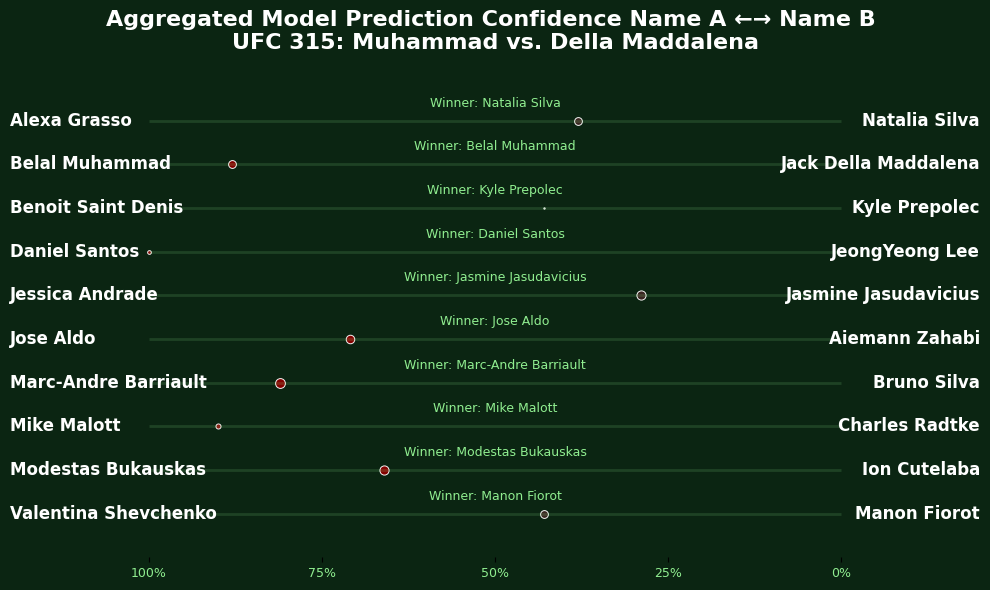

In [6]:
import matplotlib.pyplot as plt

# Reverse DataFrame so first entry appears at the top
summary_df1 = summary_df.iloc[::-1].reset_index(drop=True)

# Set up figure with forest background
fig, ax = plt.subplots(figsize=(10, 0.6 * len(summary_df1)))
fig.patch.set_facecolor('#0b2512')  # dark forest green background
ax.set_facecolor('#0b2512')

# Dot size scaling based on Total_Runs
min_size = 1
max_size = 50
min_runs = summary_df1['Total_Runs'].min()
max_runs = summary_df1['Total_Runs'].max()

def scale_size(runs):
    if max_runs == min_runs:
        return (min_size + max_size) / 2
    return min_size + (max_size - min_size) * ((runs - min_runs) / (max_runs - min_runs))

for i, row in summary_df1.iterrows():
    # Baseline line
    ax.hlines(y=i, xmin=0, xmax=1, color='lightgreen', alpha=0.15, linewidth=2)

    # Earth-tone color mapping for dots
    if row["Predicted_Winner"] == row["Name_A"]:
        color = '#8B0000'  # dark red for Name_A
        dot_position = row["Predicition_Agg_Confidence"]
    elif row["Predicted_Winner"] == row["Name_B"]:
        color = '#3E2723'  # dark brown for Name_B
        dot_position = 1 - row["Predicition_Agg_Confidence"]  # reversed confidence for Name_B
    else:
        color = '#8b8589'  # taupe/stone for ties
        dot_position = 0.5  # center for ties

    # Scale size for dots
    size = scale_size(row['Total_Runs'])

    # Plot the single dot for predicted winner (Name_A or Name_B)
    ax.scatter(dot_position, i, color=color, s=size,
               alpha=0.95, edgecolors='white', linewidths=0.7)

    # Fighter names — further pushed out for better readability
    ax.text(-0.2, i, row["Name_B"], va='center', ha='right',
            fontsize=12, fontweight='bold', color='white')  # Name_B pushed left
    ax.text(1.2, i, row["Name_A"], va='center', ha='left',
            fontsize=12, fontweight='bold', color='white')   # Name_A pushed right

    # Predicted winner label
    ax.text(0.5, i + 0.25, f"Winner: {row['Predicted_Winner']}",
            ha='center', va='bottom', fontsize=9,
            color='lightgreen', fontweight='medium')

# Axes formatting
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-1, len(summary_df1))
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels(['0%', '25%', '50%', '75%', '100%'],
                   color='lightgreen', fontsize=9)
ax.set_yticks([])
ax.set_title(f"Aggregated Model Prediction Confidence Name A ←→ Name B \n{Event_Title}",
             fontsize=16, color='white', pad=20, weight='bold')

# Invert x-axis (Name_A on left)
ax.invert_xaxis()

# Clean up: remove spines for a minimalistic look
for spine in ax.spines.values():
    spine.set_visible(False)
# Save the plot as a PNG file
plt.savefig('UFC315_05082025_prediction_confidence_plot.png', format='png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()
